In [13]:
import pandas as pd
df=pd.read_csv("netflix.csv")
df.columns

Index(['Unnamed: 0', 'recommendation_id', 'user_id', 'movie_id',
       'recommendation_date', 'recommendation_type', 'recommendation_score',
       'was_clicked', 'position_in_list', 'device_type', 'time_of_day',
       'algorithm_version', 'title', 'content_type', 'genre_primary',
       'genre_secondary', 'release_year', 'duration_minutes', 'rating_x',
       'language', 'country_of_origin', 'imdb_rating', 'production_budget',
       'box_office_revenue', 'number_of_seasons', 'number_of_episodes',
       'is_netflix_original', 'added_to_platform', 'content_warning', 'email',
       'first_name', 'last_name', 'age', 'gender', 'country', 'state_province',
       'city', 'subscription_plan', 'subscription_start_date', 'is_active',
       'monthly_spend', 'primary_device', 'household_size', 'created_at',
       'progress_percentage', 'watch_duration_minutes', 'rating_y',
       'sentiment_score'],
      dtype='object')

In [14]:
df['imdb_rating'].fillna(df['imdb_rating'].median(),inplace=True)

C:\Users\jayan\AppData\Local\Temp\ipykernel_8596\2511253848.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['imdb_rating'].fillna(df['imdb_rating'].median(),inplace=True)


In [11]:
df.drop(columns=['added_to_platform','country','city','country_of_origin'],axis=1,inplace=True)

In [15]:
df.drop(columns=['device_type','time_of_day','algorithm_version','genre_secondary','production_budget','recommendation_date',
    'box_office_revenue','number_of_seasons','number_of_episodes','email', 'first_name','last_name','age','gender','state_province',
    'subscription_plan', 'subscription_start_date', 'is_active',
       'monthly_spend', 'primary_device', 'household_size', 'created_at','progress_percentage', 'watch_duration_minutes', 'rating_y',
       'sentiment_score'],axis=1,inplace=True)

In [18]:
df['recommendation_score'].fillna(df['recommendation_score'].median(),inplace=True)

C:\Users\jayan\AppData\Local\Temp\ipykernel_8596\3658153185.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['recommendation_score'].fillna(df['recommendation_score'].median(),inplace=True)


In [19]:
df.drop_duplicates(inplace=True)

In [20]:
from sklearn.preprocessing import LabelEncoder

# Store the original string user_id before you encode it.
# This is useful for the recommendation function later.
df['user_id_raw'] = df['user_id']

# Create a dictionary to hold a separate encoder for each column
encoders = {}

# List of all the columns you want to label encode
categorical_cols = ['recommendation_id', 'user_id', 'movie_id', 'recommendation_type', 'content_type', 'genre_primary', 'rating_x', 'language']

# This loop creates a new encoder for each column, fits it,
# transforms the column, and saves the encoder in the dictionary.
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le # Store the fitted encoder for later use

# Convert boolean columns to integers (0 or 1)
df['was_clicked'] = df['was_clicked'].astype(int)
df['is_netflix_original'] = df['is_netflix_original'].astype(int)
df['content_warning'] = df['content_warning'].astype(int)

In [66]:
from sklearn.tree import DecisionTreeClassifier
model1=DecisionTreeClassifier()
from sklearn.model_selection import train_test_split
X=df[['user_id','movie_id','recommendation_type','recommendation_score','position_in_list','content_type',
      'genre_primary','release_year','duration_minutes','rating_x','language','imdb_rating','is_netflix_original','content_warning']]
y=df['was_clicked']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [67]:
model1.fit(X_train,y_train)
y_pred=model1.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy score:",accuracy_score(y_test,y_pred))

Accuracy score: 0.7598420485820271


In [23]:
def recommend_for_user(user_id_raw, model, df, movies_df, encoders, top_n=10):
    """
    Recommends movies for a user that they haven't been recommended before.
    """
    # Use the specific encoder for user_id from the dictionary
    user_encoder = encoders['user_id']

    # Step 1: Encode the raw user_id string to its integer representation
    if str(user_id_raw) not in user_encoder.classes_:
        print(f"User ID '{user_id_raw}' not found in training data.")
        return pd.DataFrame()

    user_id_encoded = user_encoder.transform([str(user_id_raw)])[0]

    # Step 2: Find movies the user has already seen
    seen = df[df['user_id'] == user_id_encoded]['movie_id'].unique()

    # Step 3: Filter out seen movies
    df_candidates = df[~df['movie_id'].isin(seen)].copy()
    df_candidates['user_id'] = user_id_encoded  # simulate user context

    # Step 4: Prepare feature matrix
    X_cand = df_candidates[['user_id','movie_id','recommendation_type','recommendation_score','position_in_list',
                            'content_type','genre_primary','release_year','duration_minutes','rating_x',
                            'language','imdb_rating','is_netflix_original','content_warning']]

    # Step 5: Predict click probability
    df_candidates['click_prob'] = model.predict_proba(X_cand)[:, 1]

    # Step 6: Return top recommendations
    return df_candidates.sort_values(by='click_prob', ascending=False).head(top_n)[['title', 'movie_id', 'click_prob']]

In [30]:
top_recs = recommend_for_user('user_03535', model1, df, movies, encoders)
print(top_recs)

                  title  movie_id  click_prob
55697  Princess Kingdom       209         1.0
55696  Princess Kingdom       209         1.0
17517     Queen Warrior       733         1.0
4258         Night Love       150         1.0
4259         Night Love       150         1.0
13505       Empire Love       759         1.0
26125        City Queen        92         1.0
10932       Phoenix Ice       655         1.0
19095    Family Journey       852         1.0
23904         New Dream       488         1.0


In [25]:
movies=pd.read_csv("D:\\ML\\DATASSETS\\jayanth_datasets\\movies.csv")

In [27]:
df

,Unnamed: 0,recommendation_id,user_id,movie_id,recommendation_type,recommendation_score,was_clicked,position_in_list,title,content_type,...,rating_x,language,country_of_origin,imdb_rating,is_netflix_original,added_to_platform,content_warning,country,city,user_id_raw
0,0,0,6273,770,1,0.553,0,10,First Quest,3,...,1,0,USA,7.2,0,2024-07-26,0,Canada,West Kerri,user_06326
1,1,1,2158,984,0,0.916,0,9,Queen Night,0,...,5,1,France,7.7,0,2024-01-21,0,USA,Olsonberg,user_02180
2,2,2,3508,833,2,0.816,0,2,The Mission,4,...,5,5,USA,7.1,0,2024-01-22,0,Canada,Gailport,user_03535
3,3,3,4989,717,4,0.771,0,16,Mystery Dream,4,...,7,1,USA,7.0,0,2025-04-22,0,USA,Lake Bradleystad,user_05025
4,4,4,6738,717,3,0.251,0,9,Mystery Dream,4,...,7,1,USA,7.0,0,2025-04-22,0,USA,New Raymond,user_06794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55708,55708,26667,1376,170,1,0.126,0,11,Dream Warrior,2,...,5,0,USA,1.4,0,2021-05-21,0,USA,Scottport,user_01387
55709,55709,4379,9241,429,3,0.192,0,13,Dragon Princess,2,...,9,0,USA,5.2,0,2021-03-02,1,USA,Carpenterville,user_09314
55710,55710,22274,2630,943,4,0.283,0,11,Dark Love,2,...,0,0,Japan,8.3,0,2023-07-21,0,USA,North Laura,user_02654
55711,55711,15451,4649,247,0,0.217,1,2,Love Storm,4,...,8,7,Japan,7.0,0,2024-02-13,0,USA,Watkinshaven,user_04683


In [39]:
importances=model1.feature_importances_
feature_names=['user_id','movie_id','recommendation_type','recommendation_score','position_in_list','content_type',
      'genre_primary','release_year','duration_minutes','rating_x','language','imdb_rating','is_netflix_original','content_warning']

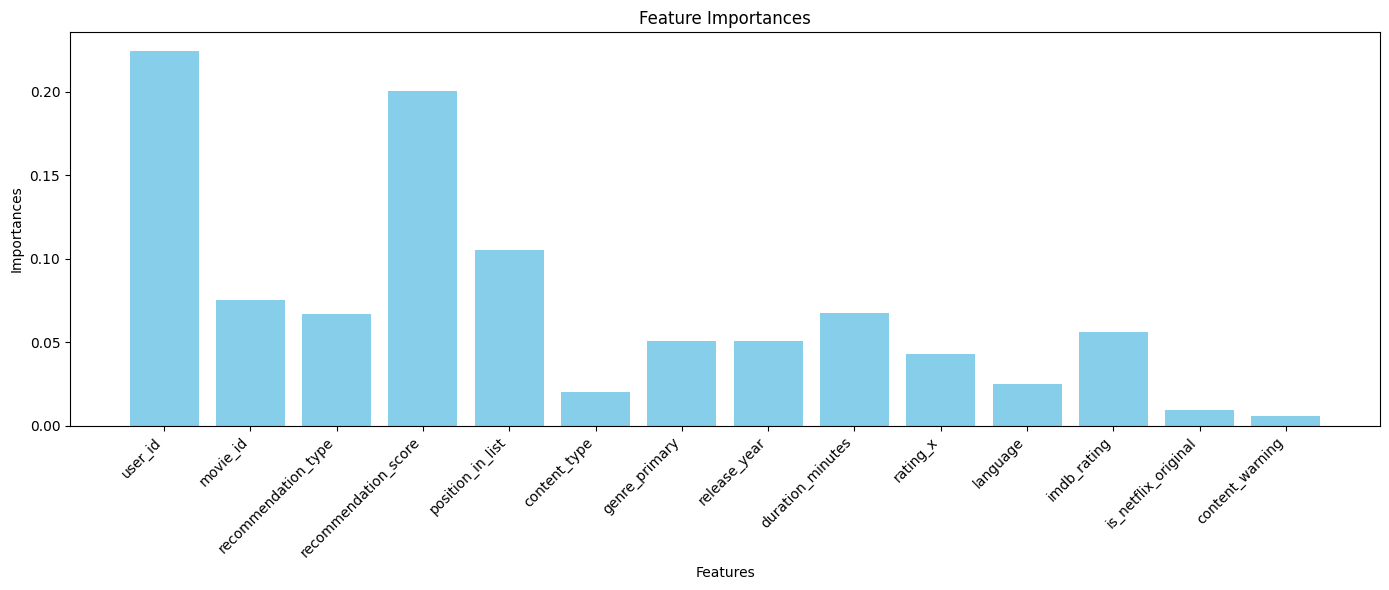

In [45]:
import matplotlib.pyplot as plt

features = feature_names
importances = importances  
plt.figure(figsize=(14, 6)) 
plt.bar(features, importances, color='skyblue')
plt.xlabel("Features")
plt.ylabel("Importances")
plt.title("Feature Importances")

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [46]:
model1.feature_importances_

array([0.22443005, 0.07524268, 0.06667041, 0.20028687, 0.10532561,
       0.0199611 , 0.05054201, 0.05051836, 0.0675743 , 0.04264938,
       0.02512733, 0.05625166, 0.00965485, 0.00576539])

In [68]:
from sklearn.ensemble import RandomForestClassifier
model2=RandomForestClassifier(n_estimators=100,random_state=42)
model2.fit(X_train,y_train)
y_pred=model2.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy for Randomforestclassifier:",accuracy_score(y_test,y_pred))

Accuracy for Randomforestclassifier: 0.8611343783654422


In [73]:
importances=model2.feature_importances_

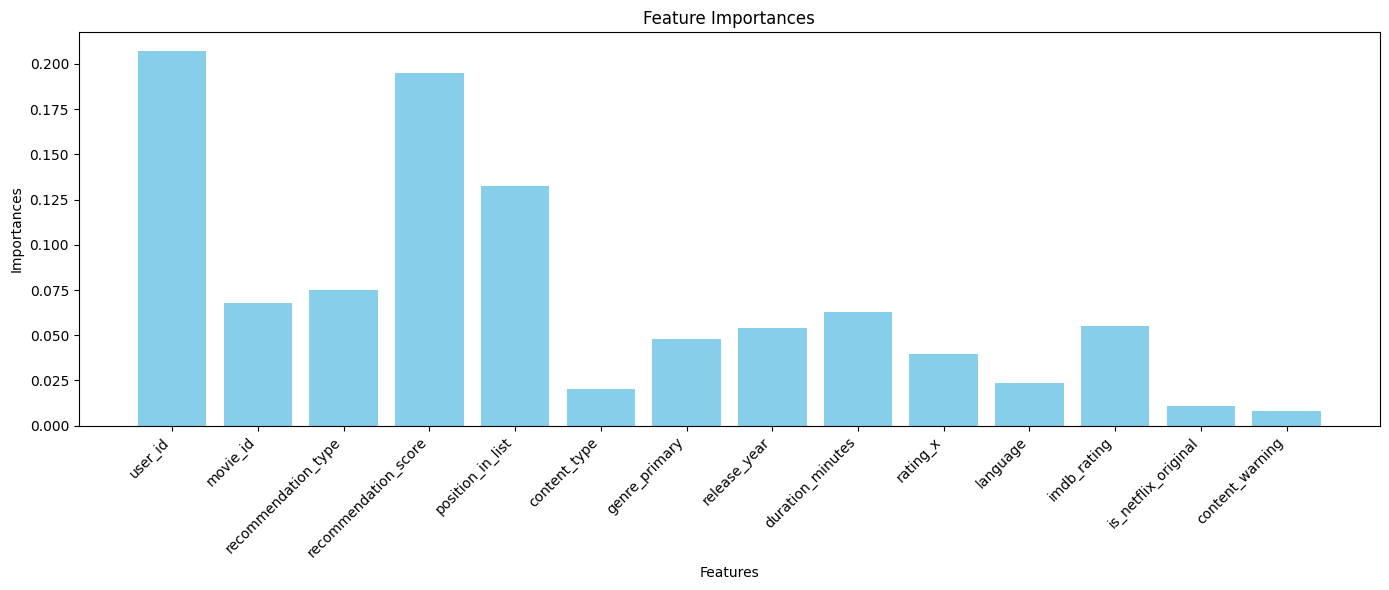

In [76]:
import matplotlib.pyplot as plt

feature2 = feature_names
importance2 = importances  
plt.figure(figsize=(14, 6)) 
plt.bar(feature2, importance2, color='skyblue')
plt.xlabel("Features")
plt.ylabel("Importances")
plt.title("Feature Importances")

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [80]:
from sklearn.neighbors import KNeighborsClassifier
model3=KNeighborsClassifier(n_neighbors=10,weights='distance')
model3.fit(X_train,y_train)
y_pred=model3.predict(X_test)
print("Accuracy for knn:",accuracy_score(y_test,y_pred))

Accuracy for knn: 0.856347971760201


In [77]:
def recommend_for_user(user_id_raw, model, df, movies_df, encoders, top_n=10):
    """
    Recommends movies for a user that they haven't been recommended before.
    """
    # Use the specific encoder for user_id from the dictionary
    user_encoder = encoders['user_id']

    # Step 1: Encode the raw user_id string to its integer representation
    if str(user_id_raw) not in user_encoder.classes_:
        print(f"User ID '{user_id_raw}' not found in training data.")
        return pd.DataFrame()

    user_id_encoded = user_encoder.transform([str(user_id_raw)])[0]

    # Step 2: Find movies the user has already seen
    seen = df[df['user_id'] == user_id_encoded]['movie_id'].unique()

    # Step 3: Filter out seen movies
    df_candidates = df[~df['movie_id'].isin(seen)].copy()
    df_candidates['user_id'] = user_id_encoded  # simulate user context

    # Step 4: Prepare feature matrix
    X_cand = df_candidates[['user_id','movie_id','recommendation_type','recommendation_score','position_in_list',
                            'content_type','genre_primary','release_year','duration_minutes','rating_x',
                            'language','imdb_rating','is_netflix_original','content_warning']]

    # Step 5: Predict click probability
    df_candidates['click_prob'] = model.predict_proba(X_cand)[:, 1]

    # Step 6: Return top recommendations
    return df_candidates.sort_values(by='click_prob', ascending=False).head(top_n)[['title', 'movie_id', 'click_prob']]

In [78]:
top_recs = recommend_for_user('user_03535', model2, df, movies, encoders)
print(top_recs)

               title  movie_id  click_prob
55514     War Battle       979        0.96
21514     War Battle       979        0.96
21513     War Battle       979        0.96
55515     War Battle       979        0.96
48193    War Phoenix       633        0.94
48192    War Phoenix       633        0.94
10510     Family Ice       206        0.93
53831     Family Ice       206        0.93
12715  Princess Love        34        0.93
10509     Family Ice       206        0.93


In [81]:
top_recs = recommend_for_user('user_03535', model3, df, movies, encoders)
print(top_recs)

             title  movie_id  click_prob
36174  Bright Love       952    0.740627
10105  Bright Love       952    0.730747
25162  Bright Love       952    0.718072
14545  Bright Love       952    0.699805
32099  Bright Love       952    0.670020
4004   Bright Love       952    0.657273
20508  Bright Love       952    0.655319
14287  Bright Love       952    0.623680
12021  First Storm       896    0.623520
54077  First Storm       896    0.623200


In [82]:
def recommend_for_user(user_id_raw, model, df, movies_df, encoders, top_n=10):
    """
    Recommend top-N unique movies for a given user based on predicted click probability.
    Removes duplicate movie_id entries and keeps the highest scoring one.
    """
    # Step 1: Encode user_id using stored encoder
    user_encoder = encoders['user_id']
    if str(user_id_raw) not in user_encoder.classes_:
        print(f"User ID '{user_id_raw}' not found in training data.")
        return pd.DataFrame()

    user_id_encoded = user_encoder.transform([str(user_id_raw)])[0]

    # Step 2: Filter out movies already seen by the user
    seen = df[df['user_id'] == user_id_encoded]['movie_id'].unique()
    df_candidates = df[~df['movie_id'].isin(seen)].copy()
    df_candidates['user_id'] = user_id_encoded  # simulate user context

    # Step 3: Prepare feature matrix for prediction
    feature_cols = ['user_id','movie_id','recommendation_type','recommendation_score','position_in_list',
                    'content_type','genre_primary','release_year','duration_minutes','rating_x',
                    'language','imdb_rating','is_netflix_original','content_warning']
    X_cand = df_candidates[feature_cols]

    # Step 4: Predict click probabilities
    df_candidates['click_prob'] = model.predict_proba(X_cand)[:, 1]

    # Step 5: Remove duplicate movie_id entries, keep highest scoring one
    df_top = df_candidates.sort_values(by='click_prob', ascending=False)
    df_unique = df_top.drop_duplicates(subset='movie_id', keep='first')

    # Step 6: Merge with movie titles if needed
    if 'title' not in df_unique.columns and 'movie_id' in movies_df.columns:
        df_unique = df_unique.merge(movies_df[['movie_id', 'title']], on='movie_id', how='left')

    # Step 7: Return top-N recommendations
    return df_unique[['title', 'movie_id', 'click_prob']].head(top_n)

In [86]:
top_recs = recommend_for_user('user_03535', model2, df, movies, encoders, top_n=10)
print(top_recs)

                  title  movie_id  click_prob
55514        War Battle       979        0.96
48193       War Phoenix       633        0.94
10510        Family Ice       206        0.93
12715     Princess Love        34        0.93
54264  Kingdom Princess       708        0.91
36085   Quest Adventure       347        0.89
53568     Mystery Quest       806        0.88
54287         The Storm       326        0.88
55337         My Dragon       762        0.87
767       Story Warrior       919        0.87
